Saving DadosCase.csv to DadosCase (39).csv
Acurácia: 0.775

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.90      0.83      0.87       352
           1       0.22      0.35      0.27        48

    accuracy                           0.78       400
   macro avg       0.56      0.59      0.57       400
weighted avg       0.82      0.78      0.80       400



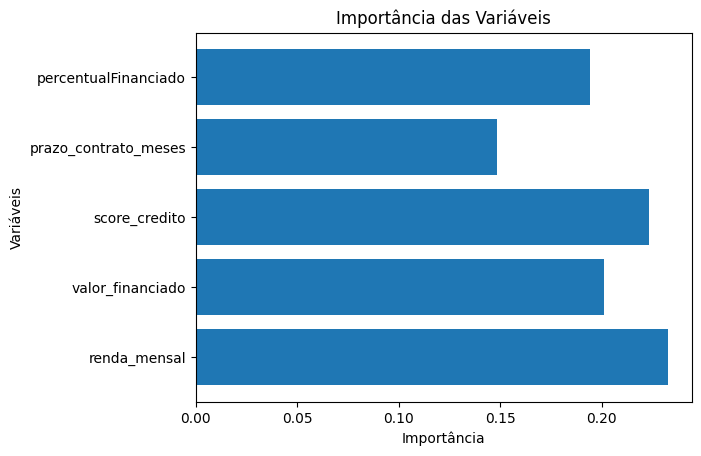

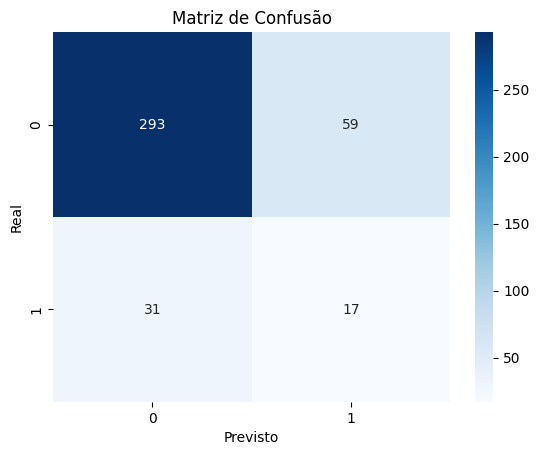

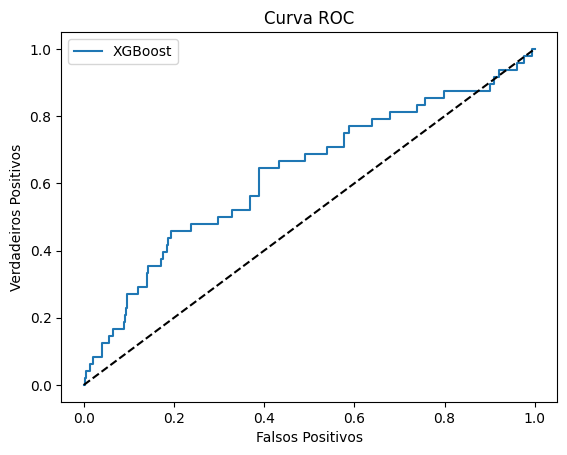

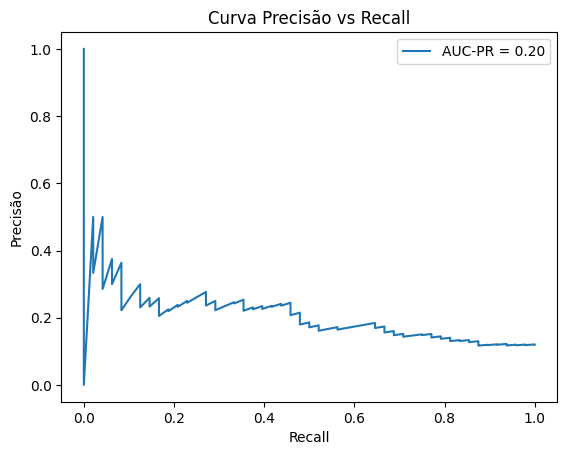

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc

from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from google.colab import files

#Importar o dataset
def carregar_dados():
    uploaded = files.upload()
    df = pd.read_csv('DadosCase.csv')
    return df

#Converter colunas String para float
def converter_float(valorString):
    valorString = valorString.replace("R$", "").replace(".", "").replace(",", ".")
    return float(valorString)


#Transformando dados String em float e criando uma coluna na tabela
def tratar_dados(df):
    df['renda_mensal'] = df['renda_mensal'].apply(converter_float)
    df['valor_imovel'] = df['valor_imovel'].apply(converter_float)
    df['valor_financiado'] = df['valor_financiado'].apply(converter_float)
    df['percentualFinanciado'] = df['valor_financiado'] / df['valor_imovel']
    return df

# Separar alvo - dividir treino e teste - balancear dados
def preparar_variaveis(df):
    y = df['inadimplente']
    x = df[['renda_mensal', 'valor_financiado', 'score_credito', 'prazo_contrato_meses', 'percentualFinanciado']]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

    ros = RandomOverSampler(random_state=42)
    x_train_bal, y_train_bal = ros.fit_resample(x_train, y_train)

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_bal)
    x_test_scaled = scaler.transform(x_test)

    return x_train_bal, x_test, y_train_bal, y_test, x.columns

# Treinar o modelo
def treinar_modelo(x_train, y_train):
    peso_classes = (y_train == 0).sum() / (y_train == 1).sum()
    modelo = XGBClassifier(
        n_estimators=100, max_depth=5, random_state=42,
        eval_metric='logloss',
        scale_pos_weight=peso_classes
    )
    modelo.fit(x_train, y_train)
    return modelo

# Avaliar o modelo com gráficos
def avaliar_modelo(modelo, x_test, y_test, colunas, threshold=0.3):
    y_proba = modelo.predict_proba(x_test)[:, 1]
    y_pred = (y_proba > threshold).astype(int)

    print("Acurácia:", accuracy_score(y_test, y_pred))
    print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

    # Importância das variáveis
    importancia = modelo.feature_importances_
    plt.barh(colunas, importancia)
    plt.title("Importância das Variáveis")
    plt.xlabel("Importância")
    plt.ylabel("Variáveis")
    plt.show()

    # Matriz de Confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Matriz de Confusão")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.show()

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label='XGBoost')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Curva ROC')
    plt.xlabel('Falsos Positivos')
    plt.ylabel('Verdadeiros Positivos')
    plt.legend()
    plt.show()

    # Curva Precisão x Recall
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
    plt.title('Curva Precisão vs Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precisão')
    plt.legend()
    plt.show()


#Gerar arquivo csv com previsão de probabilidade utilizando clientes ja cadastrados como referencia
def gerar_csv_previsoes(modelo, x_test, df_original, nome_arquivo='previsoes_clientes.csv', threshold=0.3):

    y_proba = modelo.predict_proba(x_test)[:, 1]

    #DataFrame com ID do cliente e a probabilidade
    df_resultados = pd.DataFrame({
        'id_cliente': df_original.loc[x_test.index, 'id_cliente'].values,
        'prob_inadimplencia': y_proba
    }).sort_values(by='prob_inadimplencia', ascending=False)

    # Salva em CSV
    df_resultados.to_csv(nome_arquivo, index=False)

    files.download(nome_arquivo)

# PROGRAMA PRINCIPAL
def main():
    df = carregar_dados()
    df = tratar_dados(df)
    x_train, x_test, y_train, y_test, colunas = preparar_variaveis(df)
    modelo = treinar_modelo(x_train, y_train)
    avaliar_modelo(modelo, x_test, y_test, colunas, threshold=0.3)


    df['id_cliente'] = df.index
    gerar_csv_previsoes(modelo, x_test, df)


main()
